<a href="https://colab.research.google.com/github/dbckz/crossing-the-line/blob/master/notebooks/processing_euro_final_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
import pandas as pd
import numpy as np
import ast
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
from google.colab import drive
import plotly.graph_objects as go

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Set up paths
root_path = "/content/drive/MyDrive/University/Dissertation/data_collection"
graph_path = root_path + "/graphs"

day_paths = day_paths = [
        "/28",
        "/29",
        "/30",
        "/31",
        "/32",
        "/33",
        "/34",
        "/35",
        "/36"
    ]

In [6]:
# Load data
threshold = '50'
in_tweets = pd.DataFrame()
hb_guard = pd.DataFrame()
emojis = pd.DataFrame()
persp = pd.DataFrame()

for path in day_paths:
    directory = root_path + path
    tweets_csv = directory + "/tweets.csv"
    matched_terms_csv = directory + "/hatebase_processed_tweets.csv"
    persp_csv = directory + "/perspective_processed_tweets.csv"
    emojis_csv = directory + "/emoji.csv"

    print(f"Loading CSVs for directory {path}...")
    in_tweets = pd.concat([in_tweets, 
                           pd.read_csv(tweets_csv,
                                       usecols = [
                                                  'created_at',
                                                  'tweet_id',
                                                  'tweet_text',
                                                  'accounts_mentioned'
                                       ],
                                       dtype = {
                                          # 'created_at':
                                          'tweet_id': np.int64,
                                          'tweet_text': str,
                                          'accounts_mentioned': object
                                       },
                                       parse_dates=['created_at'])])

    hb_guard = pd.concat([hb_guard, pd.read_csv(matched_terms_csv,
                                                usecols = [
                                                           'tweet_id',
                                                           f'matching_hatebase_terms_over_{threshold}',
                                                           f'matching_hatebase_terms_ethnicity_over_{threshold}',
                                                           f'matching_hatebase_terms_nationality_over_{threshold}',
                                                           f'matching_hatebase_terms_gender_over_{threshold}',
                                                           f'matching_hatebase_terms_sexual_orientation_over_{threshold}',
                                                           f'matching_hatebase_terms_class_over_{threshold}',
                                                           f'matching_hatebase_terms_religion_over_{threshold}',
                                                           f'matching_hatebase_terms_disability_over_{threshold}'
                                                ],
                                                dtype = {
                                                    'tweet_id': np.int64,
                                                    f'matching_hatebase_terms_over_{threshold}': str,
                                                    f'matching_hatebase_terms_ethnicity_over_{threshold}': str,
                                                    f'matching_hatebase_terms_nationality_over_{threshold}': str,
                                                    f'matching_hatebase_terms_gender_over_{threshold}': str,
                                                    f'matching_hatebase_terms_sexual_orientation_over_{threshold}': str,
                                                    f'matching_hatebase_terms_class_over_{threshold}': str,
                                                    f'matching_hatebase_terms_religion_over_{threshold}': str,
                                                    f'matching_hatebase_terms_disability_over_{threshold}': str
                                                })])

    emojis = pd.concat([emojis,
                        pd.read_csv(emojis_csv,
                                    dtype = {
                                        'tweet_id': np.int64,
                                        'banana_count': np.int16,
                                        'monkey_count': np.int16,
                                        'monkey_face_count': np.int16,
                                        'speak_no_evil_monkey_count': np.int16,
                                        'hear_no_evil_monkey_count': np.int16,
                                        'see_no_evil_monkey_count': np.int16,
                                        'gorilla_count': np.int16,
                                        'watermelon_count': np.int16,
                                        'total_emoji_count': np.int16
                                    }
                                    )])
    
    persp = pd.concat([persp, pd.read_csv(persp_csv,
                                          usecols = [
                                                      'tweet_id',
                                                      'identity_attack_score',
                                                      'threat_score',
                                                      'severe_toxicity_score',
                                                      'insult_score'
                                                      
                                          ],
                                          dtype = {
                                              'tweet_id': np.int64,
                                              'identity_attack_score': float,
                                              'threat_score': float,
                                              'severe_toxicity_score': float,
                                              'insult_score': float
                                          })])

# Dedup
original_tweets_length = len(in_tweets)
original_hatebase_length = len(hb_guard)
original_persp_length = len(persp)
original_emojis_length = len(emojis)
in_tweets.drop_duplicates(subset=['tweet_id'], inplace=True)
hb_guard.drop_duplicates(subset=['tweet_id'], inplace=True)
emojis.drop_duplicates(subset=['tweet_id'], inplace=True)
persp.drop_duplicates(subset=['tweet_id'], inplace=True)

print(f"Size of tweets dataframe: {len(in_tweets)}, having dropped {original_tweets_length - len(in_tweets)} duplicate rows")
print(f"Size of hatebase dataframe: {len(hb_guard)}, having dropped {original_hatebase_length - len(hb_guard)} duplicate rows")
print(f"Size of emojis dataframe: {len(emojis)}, having dropped {original_emojis_length - len(emojis)} duplicate rows")
print(f"Size of perspective dataframe: {len(persp)}, having dropped {original_persp_length - len(persp)} duplicate rows")

Loading CSVs for directory /28...
Loading CSVs for directory /29...
Loading CSVs for directory /30...
Loading CSVs for directory /31...
Loading CSVs for directory /32...
Loading CSVs for directory /33...
Loading CSVs for directory /34...
Loading CSVs for directory /35...
Loading CSVs for directory /36...
Size of tweets dataframe: 590118, having dropped 116 duplicate rows
Size of hatebase dataframe: 590118, having dropped 116 duplicate rows
Size of emojis dataframe: 590118, having dropped 116 duplicate rows
Size of perspective dataframe: 590118, having dropped 125 duplicate rows


In [7]:
# Up the pandas display limits so printed dataframes aren't so truncated
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Data manipulation

In [8]:
# Join tables + drop old ones!
joined_df = pd.merge(in_tweets, emojis, how='outer', on='tweet_id')
joined_df = pd.merge(joined_df, hb_guard, how='outer', on='tweet_id')
joined_df = pd.merge(joined_df, persp, how='outer', on='tweet_id')
del emojis
del hb_guard
del in_tweets
del persp

In [9]:
joined_df = joined_df[(joined_df['created_at'] > '2021-07-10 00:00:00+00:00') & (joined_df['created_at'] < '2021-07-17 00:00:00+00:00')]
len(joined_df)

561000

In [10]:
# Create a column indicating whether tweet contains slurs (hacky > 2 as empty list is stored as string "[]")
joined_df['contains_slurs'] = joined_df[f'matching_hatebase_terms_over_{threshold}'].str.len() > 2
joined_df['contains_ethnicity_slurs'] = joined_df[f'matching_hatebase_terms_ethnicity_over_{threshold}'].str.len() > 2
joined_df['contains_nationality_slurs'] = joined_df[f'matching_hatebase_terms_nationality_over_{threshold}'].str.len() > 2
joined_df['contains_gender_slurs'] = joined_df[f'matching_hatebase_terms_gender_over_{threshold}'].str.len() > 2
joined_df['contains_sexual_orientation_slurs'] = joined_df[f'matching_hatebase_terms_sexual_orientation_over_{threshold}'].str.len() > 2
joined_df['contains_class_slurs'] = joined_df[f'matching_hatebase_terms_class_over_{threshold}'].str.len() > 2
joined_df['contains_religion_slurs'] = joined_df[f'matching_hatebase_terms_religion_over_{threshold}'].str.len() > 2
joined_df['contains_disability_slurs'] = joined_df[f'matching_hatebase_terms_disability_over_{threshold}'].str.len() > 2


In [11]:
banana_tweet_count = joined_df['banana_count'][joined_df['banana_count'] != 0].count()
monkey_tweet_count = joined_df['monkey_count'][joined_df['banana_count'] != 0].count()
monkey_face_tweet_count = joined_df['monkey_face_count'][joined_df['monkey_face_count'] != 0].count()
speak_no_evil_monkey_tweet_count = joined_df['speak_no_evil_monkey_count'][joined_df['speak_no_evil_monkey_count'] != 0].count()
hear_no_evil_monkey_tweet_count = joined_df['hear_no_evil_monkey_count'][joined_df['hear_no_evil_monkey_count'] != 0].count()
see_no_evil_monkey_tweet_count = joined_df['see_no_evil_monkey_count'][joined_df['see_no_evil_monkey_count'] != 0].count()
gorilla_tweet_count = joined_df['gorilla_count'][joined_df['gorilla_count'] != 0].count()
watermelon_tweet_count = joined_df['watermelon_count'][joined_df['watermelon_count'] != 0].count()

banana_total = joined_df['banana_count'][joined_df['banana_count'] != 0].sum()
monkey_total = joined_df['monkey_count'][joined_df['monkey_count'] != 0].sum()
monkey_face_total = joined_df['monkey_face_count'][joined_df['monkey_face_count'] != 0].sum()
speak_no_evil_monkey_total = joined_df['speak_no_evil_monkey_count'][joined_df['speak_no_evil_monkey_count'] != 0].sum()
hear_no_evil_monkey_total = joined_df['hear_no_evil_monkey_count'][joined_df['hear_no_evil_monkey_count'] != 0].sum()
see_no_evil_monkey_total = joined_df['see_no_evil_monkey_count'][joined_df['see_no_evil_monkey_count'] != 0].sum()
gorilla_total = joined_df['gorilla_count'][joined_df['gorilla_count'] != 0].sum()
watermelon_total = joined_df['watermelon_count'][joined_df['watermelon_count'] != 0].sum()

total_emoji_tweets = joined_df.query('banana_count != 0 or monkey_count != 0 or monkey_face_count != 0 or speak_no_evil_monkey_count != 0 or hear_no_evil_monkey_count != 0 or see_no_evil_monkey_count != 0 or gorilla_count != 0 or watermelon_count != 0')['tweet_id'].count()
total_emoji_count = joined_df['total_emoji_count'][joined_df['total_emoji_count'] != 0].sum()

joined_df['contains_emoji_slurs'] = joined_df['total_emoji_count'] > 0

In [12]:
# Extract England players
list_of_players = ["JPickford1", "kylewalker2", "LukeShaw23", "_DeclanRice", "HarryMaguire93", "JackGrealish",
                    "JHenderson", "HKane", "sterling7", "MarcusRashford", "trippier2", "deanhenderson",
                    "Kalvinphillips", "OfficialTM_3", "Sanchooo10", "CalvertLewin14", "masonmount_10", "PhilFoden",
                    "BenChilwell", "ben6white", "samjohnstone50", "reecejames_24", "BukayoSaka87", "BellinghamJude"]

for player in list_of_players:
    print(f"Extracting {player}...")
    joined_df[player] = joined_df['accounts_mentioned'].str.contains(f"'username': '{player}'").astype(bool)

Extracting JPickford1...
Extracting kylewalker2...
Extracting LukeShaw23...
Extracting _DeclanRice...
Extracting HarryMaguire93...
Extracting JackGrealish...
Extracting JHenderson...
Extracting HKane...
Extracting sterling7...
Extracting MarcusRashford...
Extracting trippier2...
Extracting deanhenderson...
Extracting Kalvinphillips...
Extracting OfficialTM_3...
Extracting Sanchooo10...
Extracting CalvertLewin14...
Extracting masonmount_10...
Extracting PhilFoden...
Extracting BenChilwell...
Extracting ben6white...
Extracting samjohnstone50...
Extracting reecejames_24...
Extracting BukayoSaka87...
Extracting BellinghamJude...


In [13]:
# Sort by ascending date
joined_df.sort_values('created_at', axis=0, inplace=True)

joined_df['contains_slurs_or_offensive_emoji'] = joined_df['contains_slurs'] | joined_df['contains_emoji_slurs']

In [14]:
joined_df = joined_df[
    (joined_df["JPickford1"]) |
    (joined_df["kylewalker2"]) |
    (joined_df["LukeShaw23"]) |
    (joined_df["kylewalker2"]) |
    (joined_df["_DeclanRice"]) |
    (joined_df["HarryMaguire93"]) |
    (joined_df["JackGrealish"]) |
    (joined_df["JHenderson"]) |
    (joined_df["HKane"]) |
    (joined_df["sterling7"]) |
    (joined_df["MarcusRashford"]) |
    (joined_df["trippier2"]) |
    (joined_df["deanhenderson"]) |
    (joined_df["Kalvinphillips"]) |
    (joined_df["OfficialTM_3"]) |
    (joined_df["Sanchooo10"]) |
    (joined_df["CalvertLewin14"]) |
    (joined_df["masonmount_10"]) |
    (joined_df["PhilFoden"]) |
    (joined_df["BenChilwell"]) |
    (joined_df["ben6white"]) |
    (joined_df["samjohnstone50"]) |
    (joined_df["reecejames_24"]) |
    (joined_df["BukayoSaka87"]) |
    (joined_df["BellinghamJude"])
    ]

In [15]:
threshold_p = 0.5

joined_df['persp_over_threshold'] = (joined_df['identity_attack_score'] > threshold_p) | (joined_df['threat_score'] > threshold_p) | (joined_df['severe_toxicity_score'] > threshold_p)
                                                                                 

<ipython-input-15-96209b47e4e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_df['persp_over_threshold'] = (joined_df['identity_attack_score'] > threshold_p) | (joined_df['threat_score'] > threshold_p) | (joined_df['severe_toxicity_score'] > threshold_p)


In [16]:
h_tweets = joined_df['contains_slurs_or_offensive_emoji'].sum()
p_tweets = joined_df['persp_over_threshold'].sum()
total_tweets = len(joined_df)
print(f"Total tweets containing Hatebase slurs: {h_tweets}")
print(f"Total tweets flagged by Perspective: {p_tweets}")
print(f"Total tweets: {total_tweets}")
print(f"Percentage of tweets containing Hatebase slurs: {(100*h_tweets)/total_tweets}%")
print(f"Percentage of tweets flagged by Perspective: {(100*p_tweets)/total_tweets}%")

Total tweets containing Hatebase slurs: 7212
Total tweets flagged by Perspective: 65088
Total tweets: 446319
Percentage of tweets containing Hatebase slurs: 1.615884602716891%
Percentage of tweets flagged by Perspective: 14.583291323022323%


In [17]:
for player in list_of_players:
    joined_df[f'{player}_offensive_h'] = joined_df['contains_slurs_or_offensive_emoji'] & joined_df[player]
    joined_df[f'{player}_ethnicity'] = joined_df['contains_ethnicity_slurs'] & joined_df[player]
    joined_df[f'{player}_nationality'] = joined_df['contains_nationality_slurs'] & joined_df[player]
    joined_df[f'{player}_gender'] = joined_df['contains_gender_slurs'] & joined_df[player]
    joined_df[f'{player}_sexual_orientation'] = joined_df['contains_sexual_orientation_slurs'] & joined_df[player]
    joined_df[f'{player}_class'] = joined_df['contains_class_slurs'] & joined_df[player]
    joined_df[f'{player}_religion'] = joined_df['contains_religion_slurs'] & joined_df[player]
    joined_df[f'{player}_disability'] = joined_df['contains_disability_slurs'] & joined_df[player]
    joined_df[f'{player}_emoji'] = joined_df['contains_emoji_slurs'] & joined_df[player]
    joined_df[f'{player}_offensive_p'] = joined_df['persp_over_threshold'] & joined_df[player]

<ipython-input-17-5df23a575e59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_df[f'{player}_offensive_h'] = joined_df['contains_slurs_or_offensive_emoji'] & joined_df[player]
<ipython-input-17-5df23a575e59>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_df[f'{player}_ethnicity'] = joined_df['contains_ethnicity_slurs'] & joined_df[player]
<ipython-input-17-5df23a575e59>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [18]:
player_offensive_tweet_map = pd.DataFrame(columns=["username",
                                                   "tweets_received",
                                                   "offensive_tweets_received_h",
                                                   "offensive_tweets_received_p",
                                                   "ethnicity_tweets_received",
                                                   "nationality_tweets_received",
                                                   "gender_tweets_received",
                                                   "sexual_orientation_tweets_received",
                                                   "class_tweets_received",
                                                   "religion_tweets_received",
                                                   "disability_tweets_received",
                                                   "emoji_tweets_received",
                                                   "percentage_offensive_h",
                                                   "percentage_offensive_p",
                                                   "ethnicity_tweets_received_p",
                                                   "nationality_tweets_received_p",
                                                   "gender_tweets_received_p",
                                                   "sexual_orientation_tweets_received_p",
                                                   "class_tweets_received_p",
                                                   "religion_tweets_received_p",
                                                   "disability_tweets_received_p",
                                                   "emoji_tweets_received_p"
                                                   ])

i = 0
for player in list_of_players:
    off_tweets_h = joined_df[player + '_offensive_h'].sum()
    off_tweets_p = joined_df[player + '_offensive_p'].sum()
    ethnicity_tweets = joined_df[player + '_ethnicity'].sum()
    nationality_tweets = joined_df[player + '_nationality'].sum()
    gender_tweets = joined_df[player + '_gender'].sum()
    sexual_orientation_tweets = joined_df[player + '_sexual_orientation'].sum()
    class_tweets = joined_df[player + '_class'].sum()
    religion_tweets = joined_df[player + '_religion'].sum()
    disability_tweets = joined_df[player + '_disability'].sum()
    emoji_tweets = joined_df[player + '_emoji'].sum()
    tweets = joined_df[player].sum()
    percentage_h = 100 * (off_tweets_h / tweets)
    percentage_p = 100 * (off_tweets_p / tweets)
    ethnicity_tweets_p = (joined_df[player + '_ethnicity'] & joined_df['persp_over_threshold']).sum()
    nationality_tweets_p = (joined_df[player + '_nationality'] & joined_df['persp_over_threshold']).sum()
    gender_tweets_p = (joined_df[player + '_gender'] & joined_df['persp_over_threshold']).sum()
    sexual_orientation_tweets_p = (joined_df[player + '_sexual_orientation'] & joined_df['persp_over_threshold']).sum()
    class_tweets_p = (joined_df[player + '_class'] & joined_df['persp_over_threshold']).sum()
    religion_tweets_p = (joined_df[player + '_religion'] & joined_df['persp_over_threshold']).sum()
    disability_tweets_p = (joined_df[player + '_disability'] & joined_df['persp_over_threshold']).sum()
    emoji_tweets_p = (joined_df[player + '_emoji'] & joined_df['persp_over_threshold']).sum()
    player_offensive_tweet_map.loc[i] = player, tweets, off_tweets_h, off_tweets_p, ethnicity_tweets, nationality_tweets, gender_tweets, sexual_orientation_tweets, class_tweets, religion_tweets, disability_tweets, emoji_tweets, percentage_h, percentage_p, ethnicity_tweets_p, nationality_tweets_p, gender_tweets_p, sexual_orientation_tweets_p, class_tweets_p, religion_tweets_p, disability_tweets_p, emoji_tweets_p
    i += 1

In [19]:
name_map = {
    "JPickford1": "Jordan Pickford",
    "kylewalker2": "Kyle Walker",
    "Kalvinphillips": "Kalvin Phillips",
    "ben6white": "Benjamin White",
    "trippier2": "Kieran Trippier",
    "JHenderson": "Jordan Henderson",
    "PhilFoden": "Phil Foden",
    "sterling7": "Raheem Sterling",
    "LukeShaw23": "Luke Shaw",
    "_DeclanRice": "Declan Rice",
    "BellinghamJude": "Jude Bellingham",
    "JackGrealish": "Jack Grealish",
    "HarryMaguire93": "Harry Maguire",
    "MarcusRashford": "Marcus Rashford",
    "BukayoSaka87": "Bukayo Saka",
    "HKane": "Harry Kane",
    "deanhenderson": "Dean Henderson",
    "OfficialTM_3": "Tyrone Mings",
    "Sanchooo10": "Jadon Sancho",
    "CalvertLewin14": "Dominic Calvert-Lewin",
    "masonmount_10": "Mason Mount",
    "BenChilwell": "Ben Chilwell",
    "samjohnstone50": "Sam Johnstone",
    "reecejames_24": "Reece James"
}

player_offensive_tweet_map["player"] = player_offensive_tweet_map["username"].map(name_map)


In [20]:
player_offensive_tweet_map.sort_values('tweets_received', inplace=True)

fig = go.Figure(data=[
    go.Bar(name='offensive', y=player_offensive_tweet_map.player, x=player_offensive_tweet_map.offensive_tweets_received_p, marker_color = "darkred", orientation = 'h'),
    go.Bar(name='total', y=player_offensive_tweet_map.player, x=player_offensive_tweet_map.tweets_received, marker_color="lightgrey", orientation = 'h')
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.update_xaxes(type="log")

fig.show()

In [21]:
fig = go.Figure(data=[
    go.Bar(name='offensive', y=player_offensive_tweet_map.sort_values('offensive_tweets_received_p', axis=0, ascending=True, inplace=False).player, x=player_offensive_tweet_map.sort_values('offensive_tweets_received_p', axis=0, ascending=True, inplace=False).offensive_tweets_received_p, marker_color = "darkred", orientation = 'h')
])
# Change the bar mode

fig.show()

In [22]:
# Create dataframe for analysing abuse by type - Hatebase
slurs_by_type = pd.DataFrame(columns=["type", "total"])
slurs_by_type.loc[0] = "ethnicity", joined_df['contains_ethnicity_slurs'].sum()
slurs_by_type.loc[1] = "nationality", joined_df['contains_nationality_slurs'].sum()
slurs_by_type.loc[2] = "gender", joined_df['contains_gender_slurs'].sum()
slurs_by_type.loc[3] = "sexual_orientation", joined_df['contains_sexual_orientation_slurs'].sum()
slurs_by_type.loc[4] = "class", joined_df['contains_class_slurs'].sum()
slurs_by_type.loc[5] = "religion", joined_df['contains_religion_slurs'].sum()
slurs_by_type.loc[6] = "disability", joined_df['contains_disability_slurs'].sum()
slurs_by_type.loc[7] = "emoji", joined_df['contains_emoji_slurs'].sum()


In [23]:
# Create dataframe for analysing abuse by type - Perspective
slurs_by_type_p = pd.DataFrame(columns=["type", "total"])
slurs_by_type_p.loc[0] = "ethnicity", (joined_df['contains_ethnicity_slurs'] & joined_df['persp_over_threshold']).sum()
slurs_by_type_p.loc[1] = "nationality", (joined_df['contains_nationality_slurs'] & joined_df['persp_over_threshold']).sum()
slurs_by_type_p.loc[2] = "gender", (joined_df['contains_gender_slurs'] & joined_df['persp_over_threshold']).sum()
slurs_by_type_p.loc[3] = "sexual_orientation", (joined_df['contains_sexual_orientation_slurs'] & joined_df['persp_over_threshold']).sum()
slurs_by_type_p.loc[4] = "class", (joined_df['contains_class_slurs'] & joined_df['persp_over_threshold']).sum()
slurs_by_type_p.loc[5] = "religion", (joined_df['contains_religion_slurs'] & joined_df['persp_over_threshold']).sum()
slurs_by_type_p.loc[6] = "disability", (joined_df['contains_disability_slurs'] & joined_df['persp_over_threshold']).sum()
slurs_by_type_p.loc[7] = "emoji", (joined_df['contains_emoji_slurs'] & joined_df['persp_over_threshold']).sum()

# Analysis

In [24]:
# Print some headline figures
print(f"Earliest tweet: {joined_df['created_at'].min()}")
print(f"Latest tweet: {joined_df['created_at'].max()}")

print(f"Number of tweets (player-only): {len(joined_df)}")

Earliest tweet: 2021-07-10 08:51:00+00:00
Latest tweet: 2021-07-16 23:59:28+00:00
Number of tweets (player-only): 446319


In [25]:
# After the final - approximate
a = joined_df[(joined_df['created_at'] > '2021-07-11 21:45:00+00:00')]
hateful_tweets = a['persp_over_threshold'].sum()
hateful_mentions = player_offensive_tweet_map['offensive_tweets_received_p'].sum() 
total_tweets = len(a)
print(f"Total tweets: {total_tweets}")
print(f"Hateful tweets: {hateful_tweets}")
print(f"Percenage: {100 * (hateful_tweets / total_tweets)}%")
print(f"Hateful mentions (i.e. not unique tweets): {hateful_mentions}")


Total tweets: 405880
Hateful tweets: 61706
Percenage: 15.203015669656056%
Hateful mentions (i.e. not unique tweets): 87091


In [26]:
print(player_offensive_tweet_map[['username', 'offensive_tweets_received_p']].sort_values('offensive_tweets_received_p', ascending=False).head(10))

          username offensive_tweets_received_p
9   MarcusRashford                       32929
22    BukayoSaka87                       19008
14      Sanchooo10                       10584
13    OfficialTM_3                        6894
5     JackGrealish                        3777
7            HKane                        3635
8        sterling7                        2233
4   HarryMaguire93                        1920
2       LukeShaw23                         965
3      _DeclanRice                         908


In [27]:
# Percentage of hateful mentions that were directed at Saka, Sancho, Rashford
three_lions_perc = player_offensive_tweet_map[['offensive_tweets_received_p']].sort_values('offensive_tweets_received_p', ascending=False).head(3).sum() / hateful_mentions
print(f"{100 * three_lions_perc}%")


offensive_tweets_received_p    71.78813
dtype: object%


In [28]:
print('Five-minute intervals with most offensive tweets:')
print(joined_df.resample(pd.offsets.Minute(5), on='created_at')['contains_slurs_or_offensive_emoji'].sum().sort_values(ascending=False).head(5))
print('\n')
print('1 hour intervals with most offensive tweets:')
print(joined_df.resample(pd.offsets.Hour(1), on='created_at')['contains_slurs_or_offensive_emoji'].sum().sort_values(ascending=False).head(5))
print('\n')
print('24 hour intervals with most offensive tweets:')
print(joined_df.resample(pd.offsets.Day(1), on='created_at')['contains_slurs_or_offensive_emoji'].sum().sort_values(ascending=False).head(5))
print('\n')

tweets_containing_slurs = joined_df['contains_slurs_or_offensive_emoji'].sum()
print(f"{tweets_containing_slurs} tweets containing slurs, {100 * (tweets_containing_slurs / len(joined_df))}% of all tweets aimed at players")

Five-minute intervals with most offensive tweets:
created_at
2021-07-11 22:05:00+00:00    130
2021-07-11 21:55:00+00:00    124
2021-07-11 22:50:00+00:00    119
2021-07-11 22:00:00+00:00    116
2021-07-11 22:55:00+00:00    110
Name: contains_slurs_or_offensive_emoji, dtype: int64


1 hour intervals with most offensive tweets:
created_at
2021-07-11 22:00:00+00:00    1151
2021-07-11 23:00:00+00:00     701
2021-07-12 20:00:00+00:00     259
2021-07-11 21:00:00+00:00     211
2021-07-12 21:00:00+00:00     190
Name: contains_slurs_or_offensive_emoji, dtype: int64


24 hour intervals with most offensive tweets:
created_at
2021-07-12 00:00:00+00:00    2570
2021-07-11 00:00:00+00:00    2387
2021-07-13 00:00:00+00:00    1254
2021-07-14 00:00:00+00:00     412
2021-07-15 00:00:00+00:00     287
Name: contains_slurs_or_offensive_emoji, dtype: int64


7212 tweets containing slurs, 1.6158846027168907% of all tweets aimed at players


# Visualisation - wordclouds of slurs

In [29]:
# Menthod for creating a wordcloud, and print out the most frequently used slurs
def create_slur_wordcloud(col_name):
    list_of_terms = [a for b in joined_df[col_name][joined_df[col_name] != "[]"].str.replace("'", "").str.replace("[", "").str.replace("]", "").str.split(", ") for a in b]
    wc = WordCloud(background_color="white", collocations=False).generate(" ".join(list_of_terms))
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    slur_df = pd.DataFrame(columns=["term", "count"])
    slur_df['term'] = list_of_terms
    slur_df['count'] = slur_df['count'].fillna(0)
    slur_df = slur_df.groupby(['term']).count()
    slur_df = slur_df.sort_values('count', axis=0, ascending=False)
    print(slur_df.head(20))

<ipython-input-29-894c291b18a5>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



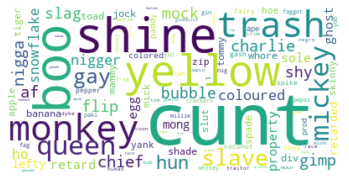

         count
term          
cunt      1378
boo        640
shine      597
yellow     444
trash      323
cunts      290
mickey     271
monkey     252
queen      250
gay        151
hun        115
slave      109
charlie     81
chief       81
flip        79
af          78
nigga       76
gimp        76
slaves      76
monkeys     72


In [30]:
create_slur_wordcloud(f"matching_hatebase_terms_over_{threshold}")

<ipython-input-29-894c291b18a5>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



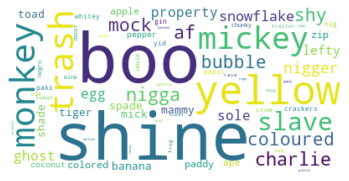

           count
term            
boo          640
shine        597
yellow       444
trash        323
mickey       271
monkey       252
slave        109
charlie       81
af            78
nigga         76
slaves        76
monkeys       72
mock          72
shy           69
bubble        67
coloured      65
snowflake     57
egg           50
property      49
ghost         49


In [31]:
create_slur_wordcloud(f"matching_hatebase_terms_ethnicity_over_{threshold}")

<ipython-input-29-894c291b18a5>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



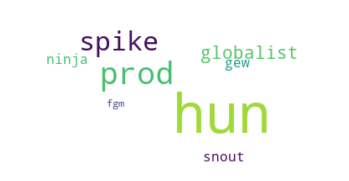

           count
term            
hun          115
prod          16
spike         12
globalist      4
gew            2
ninja          2
snout          2
fgm            1


In [32]:
create_slur_wordcloud(f"matching_hatebase_terms_religion_over_{threshold}")

<ipython-input-29-894c291b18a5>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



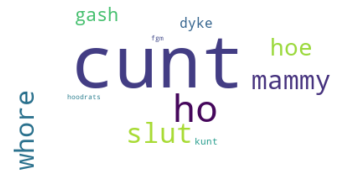

          count
term           
cunt       1378
cunts       290
ho           59
whore        25
mammy        24
slut         24
hoe          14
gash         12
hoes          6
dyke          5
sluts         3
kunt          2
fgm           1
hoodrats      1


In [33]:
create_slur_wordcloud(f"matching_hatebase_terms_gender_over_{threshold}")

<ipython-input-29-894c291b18a5>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



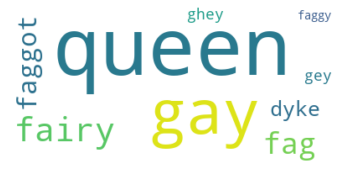

        count
term         
queen     250
gay       151
queens     26
fairy      13
fag        10
faggot      8
dyke        5
gey         2
ghey        2
faggy       1


In [34]:
create_slur_wordcloud(f"matching_hatebase_terms_sexual_orientation_over_{threshold}")

<ipython-input-29-894c291b18a5>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



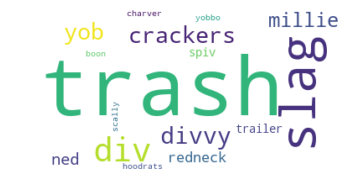

               count
term                
trash            323
slag              53
div               24
slags             14
divvy             10
crackers           9
yob                9
millie             7
ned                4
redneck            3
spiv               2
trailer trash      2
boon               1
scally             1
charver            1
hoodrats           1
yobbo              1


In [35]:
create_slur_wordcloud(f"matching_hatebase_terms_class_over_{threshold}")

<ipython-input-29-894c291b18a5>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



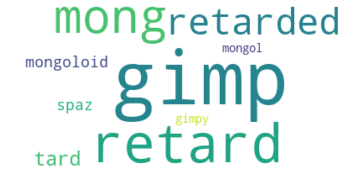

           count
term            
gimp          76
mong          41
retarded      37
retard        35
retards       17
tard           4
mongoloid      2
spaz           2
gimpy          1
mongol         1


In [36]:
create_slur_wordcloud(f"matching_hatebase_terms_disability_over_{threshold}")

<ipython-input-29-894c291b18a5>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



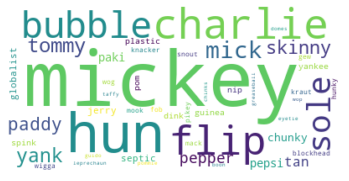

           count
term            
mickey       271
hun          115
charlie       81
flip          79
bubble        67
sole          48
mick          23
tommy         23
yank          21
skinny        20
paddy         16
pepper        13
tan            8
pepsi          7
paki           6
chunky         6
jerry          4
septic         4
globalist      4
pom            3


In [37]:
create_slur_wordcloud(f"matching_hatebase_terms_nationality_over_{threshold}")

# Visulisations - tweet frequency

In [38]:
# Setup vars for high-profile tweet times
# "id": "1415692762708680717"
saka_tweet_time = pd.to_datetime("2021-07-15T15:20:31.000Z")

# "id": "1414672529717964807"
rashford_tweet_time = pd.to_datetime("2021-07-12T19:46:29.000Z")

# "id": "1415348669809823751"
sancho_tweet_time = pd.to_datetime("2021-07-14T16:33:13.000Z")

# "id": "1414639048031805441"
kane_tweet_time = pd.to_datetime("2021-07-12T17:33:26.000Z")

# "id": "1414654985753841667"
mings_tweet_time = pd.to_datetime("2021-07-12T18:36:46.000Z")

full_time = pd.to_datetime("2021-07-11T21:55:00.000Z")

kick_off = pd.to_datetime("2021-07-11T19:00:00.000Z")

In [39]:
INTERVAL = pd.offsets.Minute(5)

In [40]:
def create_frequency_plotly(df, y_values, y_value_names, title, nticks):
    fig = go.Figure()
    i = 0
    for i in range(len(y_values)):
        fig.add_trace(go.Scatter(x=df['created_at'], y=df[y_values[i]],
                      mode='lines',
                      name=y_value_names[i]))
        
    fig.update_layout(
        xaxis_title="Time",
        yaxis_title="Number of tweets",
        xaxis = {
          'tickformat': '%d %B',
          'tickmode': 'auto',
          'nticks': nticks,
        },
        xaxis_tickformat = '%d %B',
        title= {
          'text': title,
          'y':0.9,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'
        }
    )
    return fig

def create_frequency_bars(df, y_values, title, nticks):
    fig = go.Figure()
    for y_value in y_values:
        fig.add_trace(go.Bar(x=df['created_at'], y=df[y_value],
                      name=y_value))
    fig.update_layout(
        xaxis_title="Date",
        yaxis_title="Number of tweets",
        xaxis = {
          'tickformat': '%d %B',
          'tickmode': 'auto',
          'nticks': nticks,
        },
        xaxis_tickformat = '%d %B',
        title= {
          'text': title,
          'y':0.9,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'
        }
    )

    return fig

In [41]:
# Plot all tweets frequency
df = joined_df[(joined_df['created_at'] > '2021-07-11 16:00:00+00:00') & (joined_df['created_at'] < '2021-07-15 23:00:00+00:00')].resample(pd.offsets.Minute(15), on='created_at')['tweet_id'].count().reset_index()
fig = create_frequency_bars(df, ['tweet_id'], "", 4)

y_max = max(df.iloc[(df['created_at']-full_time).abs().argsort()[:10]]['tweet_id'].tolist())
fig.add_annotation(x=kick_off, y=max(df.iloc[(df['created_at']-kick_off).abs().argsort()[:10]]['tweet_id'].tolist()) + (y_max / 100),
    text="Kick-off",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=full_time, y=y_max + (y_max / 100),
    text="End of game",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=saka_tweet_time, y=max(df.iloc[(df['created_at']-saka_tweet_time).abs().argsort()[:10]]['tweet_id'].tolist()) + (y_max / 100),
    text="Saka tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=sancho_tweet_time, y=max(df.iloc[(df['created_at']-sancho_tweet_time).abs().argsort()[:10]]['tweet_id'].tolist()) + (y_max / 100),
    text="Sancho tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=rashford_tweet_time, y=max(df.iloc[(df['created_at']-rashford_tweet_time).abs().argsort()[:10]]['tweet_id'].tolist()) + (y_max / 100),
    text="Rashford tweet",
    showarrow=True,
    arrowhead=1)
# fig.add_annotation(x=mings_tweet_time, y=max(df.iloc[(df['created_at']-mings_tweet_time).abs().argsort()[:10]]['tweet_id'].tolist()) + (y_max / 100),
#     text="Mings<br>tweet",
#     showarrow=True,
#     arrowhead=1)
fig.write_html("/content/drive/MyDrive/University/Dissertation/images/figure6a.html", include_plotlyjs='cdn')
fig.show()

In [42]:
last_tweet_before_api_broke = joined_df[joined_df['created_at'] < '2021-07-12 13:30:00+00:00'].iloc[-1]
print(f"Timestamp of last tweet before API broke: {last_tweet_before_api_broke['created_at']}")
first_tweet_after_api_restored = joined_df[joined_df['created_at'] > '2021-07-12 13:30:00+00:00'].iloc[0]
print(f"Timestamp of first tweet after API restored: {first_tweet_after_api_restored['created_at']}")

Timestamp of last tweet before API broke: 2021-07-12 12:37:49+00:00
Timestamp of first tweet after API restored: 2021-07-12 14:55:23+00:00


In [43]:
# Plot Rashford, Saka, Sancho tweet frequency
df = joined_df[(joined_df['created_at'] > '2021-07-11 16:00:00+00:00') & (joined_df['created_at'] < '2021-07-15 23:00:00+00:00')].resample(INTERVAL, on='created_at')['MarcusRashford', 'Sanchooo10', 'BukayoSaka87'].sum().reset_index()
y_values = ['MarcusRashford', 'Sanchooo10', 'BukayoSaka87']
fig = create_frequency_plotly(df, y_values, y_values, "", 6)

y_max = max(df.iloc[(df['created_at']-full_time).abs().argsort()[:10]]['BukayoSaka87'].tolist())
fig.add_annotation(x=kick_off, y=max(df.iloc[(df['created_at']-kick_off).abs().argsort()[:10]]['BukayoSaka87'].tolist()) + (y_max / 100),
    text="Kick-off",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=full_time, y=y_max + (y_max / 100),
    text="End of game",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=saka_tweet_time, y=max(df.iloc[(df['created_at']-saka_tweet_time).abs().argsort()[:10]]['BukayoSaka87'].tolist()) + (y_max / 100),
    text="Saka tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=sancho_tweet_time, y=max(df.iloc[(df['created_at']-sancho_tweet_time).abs().argsort()[:10]]['Sanchooo10'].tolist()) + (y_max / 100),
    text="Sancho tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=rashford_tweet_time, y=max(df.iloc[(df['created_at']-rashford_tweet_time).abs().argsort()[:10]]['MarcusRashford'].tolist()) + (y_max / 100),
    text="Rashford tweet",
    showarrow=True,
    arrowhead=1)

fig.show()

In [44]:
# Plot Rashford, Saka, Sancho, Mings tweet frequency
df = joined_df[(joined_df['created_at'] > '2021-07-11 16:00:00+00:00') & (joined_df['created_at'] < '2021-07-15 23:00:00+00:00')].resample(INTERVAL, on='created_at')['MarcusRashford', 'Sanchooo10', 'BukayoSaka87', 'OfficialTM_3'].sum().reset_index()
y_values = ['MarcusRashford', 'Sanchooo10', 'BukayoSaka87', 'OfficialTM_3']
fig = create_frequency_plotly(df, y_values, y_values, "", 6)

y_max = max(df.iloc[(df['created_at']-full_time).abs().argsort()[:10]]['BukayoSaka87'].tolist())
fig.add_annotation(x=kick_off, y=max(df.iloc[(df['created_at']-kick_off).abs().argsort()[:10]]['BukayoSaka87'].tolist()) + (y_max / 100),
    text="Kick-off",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=full_time, y=y_max + (y_max / 100),
    text="End of game",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=saka_tweet_time, y=max(df.iloc[(df['created_at']-saka_tweet_time).abs().argsort()[:10]]['BukayoSaka87'].tolist()) + (y_max / 100),
    text="Saka tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=sancho_tweet_time, y=max(df.iloc[(df['created_at']-sancho_tweet_time).abs().argsort()[:10]]['Sanchooo10'].tolist()) + (y_max / 100),
    text="Sancho tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=rashford_tweet_time, y=max(df.iloc[(df['created_at']-rashford_tweet_time).abs().argsort()[:10]]['MarcusRashford'].tolist()) + (y_max / 100),
    text="Rashford tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=mings_tweet_time, y=max(df.iloc[(df['created_at']-mings_tweet_time).abs().argsort()[:10]]['OfficialTM_3'].tolist()) + (y_max / 100),
    text="Mings<br>tweet",
    showarrow=True,
    arrowhead=1)
fig.show()

In [45]:
df = joined_df[(joined_df['created_at'] > '2021-07-11 16:00:00+00:00') & (joined_df['created_at'] < '2021-07-15 23:00:00+00:00')].resample(pd.offsets.Minute(15), on='created_at')['contains_slurs_or_offensive_emoji', 'persp_over_threshold'].sum().reset_index()
y_values = ['contains_slurs_or_offensive_emoji', 'persp_over_threshold']
fig = create_frequency_plotly(df, y_values, ['Hatebase', 'Perspective'], "", 6)

y_max = max(df.iloc[(df['created_at']-full_time).abs().argsort()[:20]]['contains_slurs_or_offensive_emoji'].tolist())
# fig.add_annotation(x=kick_off, y=max(df.iloc[(df['created_at']-kick_off).abs().argsort()[:10]]['contains_slurs_or_offensive_emoji'].tolist()) + (y_max / 100),
#     text="Kick-off",
#     showarrow=True,
#     arrowhead=1)
# fig.add_annotation(x=full_time, y=y_max + (y_max / 100),
#     text="End of game",
#     showarrow=True,
#     arrowhead=1)
fig.add_annotation(x=saka_tweet_time, y=max(df.iloc[(df['created_at']-saka_tweet_time).abs().argsort()[:10]]['contains_slurs_or_offensive_emoji'].tolist()) + (y_max / 100),
    text="Saka tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=sancho_tweet_time, y=max(df.iloc[(df['created_at']-sancho_tweet_time).abs().argsort()[:10]]['contains_slurs_or_offensive_emoji'].tolist()) + (y_max / 100),
    text="Sancho tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=rashford_tweet_time, y=max(df.iloc[(df['created_at']-rashford_tweet_time).abs().argsort()[:10]]['contains_slurs_or_offensive_emoji'].tolist()) + (y_max / 100),
    text="Rashford tweet",
    showarrow=True,
    arrowhead=1)
# fig.add_annotation(x=mings_tweet_time, y=max(df.iloc[(df['created_at']-mings_tweet_time).abs().argsort()[:10]]['contains_slurs_or_offensive_emoji'].tolist()) + (y_max / 100),
#     text="Mings<br>tweet",
#     showarrow=True,
#     arrowhead=1)

fig.show()

In [46]:
# Plot frequency of offensive tweets for Rashford, Sancho, Saka, Mings
df = joined_df[(joined_df['created_at'] > '2021-07-11 16:00:00+00:00') & (joined_df['created_at'] < '2021-07-15 23:00:00+00:00')].resample(pd.offsets.Minute(15), on='created_at')['BukayoSaka87_offensive_h', 'Sanchooo10_offensive_h', 'MarcusRashford_offensive_h'].sum().reset_index()
y_values = ['BukayoSaka87_offensive_h', 'Sanchooo10_offensive_h', 'MarcusRashford_offensive_h']
names = ['BukayoSaka87', 'Sanchooo10', 'MarcusRashford']
fig = create_frequency_plotly(df, y_values, names,"", 6)

y_max = max(df.iloc[(df['created_at']-full_time).abs().argsort()[:20]]['BukayoSaka87_offensive_h'].tolist())
# fig.add_annotation(x=kick_off, y=max(df.iloc[(df['created_at']-kick_off).abs().argsort()[:10]]['BukayoSaka87_offensive_h'].tolist()) + (y_max / 100),
#     text="Kick-off",
#     showarrow=True,
#     arrowhead=1)
# fig.add_annotation(x=full_time, y=y_max + (y_max / 100),
#     text="End of game",
#     showarrow=True,
#     arrowhead=1)
fig.add_annotation(x=saka_tweet_time, y=max(df.iloc[(df['created_at']-saka_tweet_time).abs().argsort()[:10]]['BukayoSaka87_offensive_h'].tolist()) + (y_max / 100),
    text="Saka tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=sancho_tweet_time, y=max(df.iloc[(df['created_at']-sancho_tweet_time).abs().argsort()[:10]]['Sanchooo10_offensive_h'].tolist()) + (y_max / 100),
    text="Sancho tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=rashford_tweet_time, y=max(df.iloc[(df['created_at']-rashford_tweet_time).abs().argsort()[:10]]['MarcusRashford_offensive_h'].tolist()) + (y_max / 100),
    text="Rashford tweet",
    showarrow=True,
    arrowhead=1)
# fig.add_annotation(x=mings_tweet_time, y=max(df.iloc[(df['created_at']-mings_tweet_time).abs().argsort()[:10]]['OfficialTM_3_offensive_h'].tolist()) + (y_max / 100),
#     text="Mings<br>tweet",
#     showarrow=True,
#     arrowhead=1)
fig.write_html("/content/drive/MyDrive/University/Dissertation/images/figure6b.html", include_plotlyjs='cdn')
fig.show()


In [47]:
# Plot frequency of offensive tweets for Rashford, Sancho, Saka, Mings
df = joined_df[(joined_df['created_at'] > '2021-07-11 16:00:00+00:00') & (joined_df['created_at'] < '2021-07-15 23:00:00+00:00')].resample(pd.offsets.Minute(15), on='created_at')['BukayoSaka87_offensive_p', 'Sanchooo10_offensive_p', 'MarcusRashford_offensive_p'].sum().reset_index()
y_values = ['BukayoSaka87_offensive_p', 'Sanchooo10_offensive_p', 'MarcusRashford_offensive_p']
names = ['BukayoSaka87', 'Sanchooo10', 'MarcusRashford']
fig = create_frequency_plotly(df, y_values, names,"", 6)

y_max = max(df.iloc[(df['created_at']-full_time).abs().argsort()[:20]]['BukayoSaka87_offensive_p'].tolist())
# fig.add_annotation(x=kick_off, y=max(df.iloc[(df['created_at']-kick_off).abs().argsort()[:10]]['BukayoSaka87_offensive_p'].tolist()) + (y_max / 100),
#     text="Kick-off",
#     showarrow=True,
#     arrowhead=1)
# fig.add_annotation(x=full_time, y=y_max + (y_max / 100),
#     text="End of game",
#     showarrow=True,
#     arrowhead=1)
fig.add_annotation(x=saka_tweet_time, y=max(df.iloc[(df['created_at']-saka_tweet_time).abs().argsort()[:10]]['BukayoSaka87_offensive_p'].tolist()) + (y_max / 100),
    text="Saka tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=sancho_tweet_time, y=max(df.iloc[(df['created_at']-sancho_tweet_time).abs().argsort()[:10]]['Sanchooo10_offensive_p'].tolist()) + (y_max / 100),
    text="Sancho tweet",
    showarrow=True,
    arrowhead=1)
fig.add_annotation(x=rashford_tweet_time, y=max(df.iloc[(df['created_at']-rashford_tweet_time).abs().argsort()[:10]]['MarcusRashford_offensive_p'].tolist()) + (y_max / 100),
    text="Rashford tweet",
    showarrow=True,
    arrowhead=1)
# fig.add_annotation(x=mings_tweet_time, y=max(df.iloc[(df['created_at']-mings_tweet_time).abs().argsort()[:10]]['OfficialTM_3_offensive_p'].tolist()) + (y_max / 100),
#     text="Mings<br>tweet",
#     showarrow=True,
#     arrowhead=1)
fig.write_html("/content/drive/MyDrive/University/Dissertation/images/figure6c.html", include_plotlyjs='cdn')
fig.show()


# Visualisations - stack charts

In [48]:
def create_stack_chart(number, tweet_map, total_type, subtype, subtype_name):
    df = tweet_map.head(number)
    data0 = go.Bar(
        x = df.username,
        y = df[subtype],
        name = subtype_name,
        text = df[subtype],
        textposition = 'inside',
        texttemplate = '%{text:.2}'
    )

    data1 = go.Bar(
        x = df.username,
        y = df[total_type] - df[subtype],
        name = 'Other',
        text = df[total_type] - df[subtype],
        textposition = 'inside',
        texttemplate = '%{text:.2}'
    )

    data = [data0, data1]

    layout = go.Layout(title = "Proportion of tweets containing abusive slurs where slurs related to ethnicity", barmode='stack')

    figure = go.Figure(data = data, layout = layout)
    figure.show()



In [49]:
create_stack_chart(4, player_offensive_tweet_map.sort_values('offensive_tweets_received_h', ascending=False), "offensive_tweets_received_h", "ethnicity_tweets_received", "Ethnicity-related")

In [50]:
create_stack_chart(4, player_offensive_tweet_map.sort_values('offensive_tweets_received_p', ascending=False), "offensive_tweets_received_p", "ethnicity_tweets_received_p", "Ethnicity-related")

In [51]:
slurs_by_type.sort_values('total', ascending=False, inplace=True)

data = go.Bar(
    x = slurs_by_type['type'],
    y = slurs_by_type.total,
    text = slurs_by_type.total,
    textposition = 'outside',
    texttemplate = '%{text:.2}'
)

layout = go.Layout(title = "Tweets containing Hatebase terms or emojis by type - Hatebase")

figure = go.Figure(data = data, layout = layout)
figure.show()

In [52]:
slurs_by_type_p.sort_values('total', ascending=False, inplace=True)

data = go.Bar(
    x = slurs_by_type_p['type'],
    y = slurs_by_type_p.total,
    text = slurs_by_type_p.total,
    textposition = 'outside',
    texttemplate = '%{text:.2}'
)

layout = go.Layout(title = "")

figure = go.Figure(data = data, layout = layout)
figure.write_html("/content/drive/MyDrive/University/Dissertation/images/figure5.html", include_plotlyjs='cdn')

figure.show()